# 15강: 전이학습과 사전훈련된 모델 활용

## 🎯 학습 목표
- 전이학습(Transfer Learning)의 개념과 원리 이해
- 사전훈련된 모델 활용법 완전 마스터
- Fine-tuning 기법으로 높은 성능 달성
- 실제 프로젝트에 전이학습 적용

---

## 📚 강의 개요 (60분)
1. 전이학습 이론 (15분)
2. 사전훈련된 모델 활용 (25분)
3. Fine-tuning 실습 (20분)

> **이전 강의 복습**: 14강에서 최적화 기법들을 배웠습니다. 이제 더 강력한 무기인 전이학습을 배워보겠습니다!


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 전이학습용 ResNet18 모델 로드
model = models.resnet18(pretrained=True)

# 마지막 층을 CIFAR-10용으로 변경 (10개 클래스)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

print("🚀 사전훈련된 ResNet18 모델 로드 완료!")
print(f"📊 전체 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

# Feature Extractor vs Fine-tuning 설정
def freeze_backbone(model):
    """백본 네트워크 동결"""
    for param in model.parameters():
        param.requires_grad = False
    model.fc.requires_grad = True  # 마지막 층만 학습

def unfreeze_all(model):
    """전체 네트워크 학습 가능"""
    for param in model.parameters():
        param.requires_grad = True

print("✅ 전이학습 설정 함수 준비 완료!")


🚀 사전훈련된 ResNet18 모델 로드 완료!
📊 전체 파라미터 수: 11,181,642
✅ 전이학습 설정 함수 준비 완료!


/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 1. 전이학습(Transfer Learning) 이론

### 🤔 전이학습이란?

**전이학습**은 한 분야(도메인)에서 학습한 지식을 다른 분야에 적용하는 기법입니다.

### 💡 인간의 학습과 비교

**인간의 경우:**
- 자전거를 탈 줄 알면 오토바이도 쉽게 배움
- 영어를 알면 독일어를 더 빨리 습득
- 그림을 그릴 줄 알면 디자인도 잘함

**딥러닝의 경우:**
- ImageNet으로 훈련된 모델을 의료 이미지 분석에 활용
- 자연어 처리 모델을 다른 언어 작업에 적용
- 게임 AI를 로봇 제어에 응용

### 🎯 전이학습의 핵심 아이디어

**왜 전이학습이 강력할까요?**

1. **특징 재사용**: 저수준 특징(선, 모서리)은 범용적
2. **데이터 효율성**: 적은 데이터로도 좋은 성능
3. **계산 효율성**: 처음부터 학습할 필요 없음
4. **성능 향상**: 사전 지식으로 더 좋은 결과

### 📊 전이학습 vs 처음부터 학습

| 구분 | 처음부터 학습 | 전이학습 |
|------|---------------|----------|
| **데이터 요구량** | 매우 많음 (수만~수십만) | 적음 (수백~수천) |
| **학습 시간** | 매우 오래 (수일~수주) | 빠름 (수시간~하루) |
| **계산 비용** | 매우 높음 | 낮음 |
| **성능** | 데이터 충분시 좋음 | 일반적으로 더 좋음 |
| **안정성** | 불안정할 수 있음 | 안정적 |


### 1.1 전이학습의 유형

#### 🔧 1) Feature Extractor (특징 추출기)

**개념**: 사전훈련된 모델을 특징 추출기로만 사용

```
[사전훈련 모델] → [고정된 특징] → [새로운 분류기]
```

**특징:**
- 사전훈련된 부분은 가중치 고정 (frozen)
- 마지막 분류 층만 새로 학습
- 빠른 학습, 안정적 결과
- 데이터가 적을 때 효과적

#### 🎯 2) Fine-tuning (미세 조정)

**개념**: 사전훈련된 모델 전체를 새로운 작업에 맞게 조정

```
[사전훈련 모델] → [전체 가중치 조정] → [새로운 작업]
```

**특징:**
- 모든 층의 가중치를 학습
- 더 좋은 성능 기대
- 학습 시간 더 오래
- 데이터가 충분할 때 효과적

#### ⚖️ 3) 부분 Fine-tuning

**개념**: 일부 층만 학습하고 나머지는 고정

```
[고정 층들] → [학습 가능 층들] → [새로운 분류기]
```

**특징:**
- 하위 층은 고정, 상위 층만 학습
- Feature Extractor와 Fine-tuning의 중간
- 계산 효율성과 성능의 균형

### 📋 전이학습 전략 선택 가이드

| 상황 | 데이터 크기 | 유사성 | 권장 전략 |
|------|-------------|--------|-----------|
| **Case 1** | 적음 | 높음 | Feature Extractor |
| **Case 2** | 적음 | 낮음 | 부분 Fine-tuning |
| **Case 3** | 많음 | 높음 | Fine-tuning |
| **Case 4** | 많음 | 낮음 | 처음부터 학습 |

**유사성**: 원본 데이터셋(ImageNet)과 새로운 작업 간의 유사성


## 2. 사전훈련된 모델 탐색

### 🏛️ 인기 있는 사전훈련 모델들

PyTorch에서 제공하는 주요 사전훈련 모델들을 살펴보겠습니다!


In [2]:
# 🏛️ 다양한 사전훈련 모델 탐색
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 사용 디바이스: {device}")

# 🔍 사전훈련 모델들 비교
pretrained_models = {
    'ResNet18': models.resnet18,
    'ResNet50': models.resnet50,
    'VGG16': models.vgg16,
    'MobileNetV2': models.mobilenet_v2,
    'EfficientNet_B0': models.efficientnet_b0
}

print("🏛️ 사용 가능한 사전훈련 모델들:")
print("=" * 60)

for name, model_fn in pretrained_models.items():
    # 모델 정보 확인
    model = model_fn(pretrained=False)  # 구조만 확인
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"{name:15}: {total_params:,}개 파라미터")

print("\n💡 모델 선택 가이드:")
print("   📱 MobileNetV2: 가벼움, 모바일용")
print("   🏠 ResNet18: 균형잡힌 성능, 초보자 추천")
print("   🔥 ResNet50: 높은 성능, 더 깊은 네트워크") 
print("   📊 VGG16: 간단한 구조, 이해하기 쉬움")
print("   ⚡ EfficientNet: 최신 기술, 효율적 설계")

print("\n✅ 모델 탐색 완료!")

# 오늘은 ResNet18로 실습진행
selected_model = 'ResNet18'
print(f"📌 선택된 모델: {selected_model}")


🚀 사용 디바이스: cuda
🏛️ 사용 가능한 사전훈련 모델들:
ResNet18       : 11,689,512개 파라미터


/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50       : 25,557,032개 파라미터
VGG16          : 138,357,544개 파라미터
MobileNetV2    : 3,504,872개 파라미터
EfficientNet_B0: 5,288,548개 파라미터

💡 모델 선택 가이드:
   📱 MobileNetV2: 가벼움, 모바일용
   🏠 ResNet18: 균형잡힌 성능, 초보자 추천
   🔥 ResNet50: 높은 성능, 더 깊은 네트워크
   📊 VGG16: 간단한 구조, 이해하기 쉬움
   ⚡ EfficientNet: 최신 기술, 효율적 설계

✅ 모델 탐색 완료!
📌 선택된 모델: ResNet18


### 2.1 데이터 준비 - CIFAR-10


In [3]:
# 📊 CIFAR-10 데이터 준비 (전이학습용)

# ImageNet 사전훈련 모델에 맞는 전처리
# ImageNet: 224x224, 평균=[0.485, 0.456, 0.406], 표준편차=[0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize(224),                    # ImageNet 크기로 확대
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet 정규화
])

transform_test = transforms.Compose([
    transforms.Resize(224),                    # ImageNet 크기로 확대  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# 빠른 실험을 위해 데이터 크기 줄이기 (전체 데이터의 20%만 사용)
train_size = int(0.2 * len(train_dataset))  # 10,000개
test_size = int(0.2 * len(test_dataset))    # 2,000개

train_subset, _ = random_split(train_dataset, [train_size, len(train_dataset) - train_size])
test_subset, _ = random_split(test_dataset, [test_size, len(test_dataset) - test_size])

# 훈련/검증 분할
val_size = int(0.2 * len(train_subset))     # 2,000개
train_size_final = len(train_subset) - val_size  # 8,000개

train_final, val_subset = random_split(train_subset, [train_size_final, val_size])

# 데이터 로더 생성
batch_size = 32  # 전이학습에서는 작은 배치 크기 사용
train_loader = DataLoader(train_final, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print("📊 전이학습용 데이터 구성:")
print(f"   훈련: {len(train_final):,}개")
print(f"   검증: {len(val_subset):,}개")
print(f"   테스트: {len(test_subset):,}개")
print(f"   배치 크기: {batch_size}")

# CIFAR-10 클래스
cifar10_classes = ['비행기', '자동차', '새', '고양이', '사슴', 
                   '개', '개구리', '말', '배', '트럭']

print(f"🏷️  클래스: {cifar10_classes}")

# 🔍 데이터 샘플 확인
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"\n📏 이미지 크기: {images.shape}")  # [배치, 채널, 높이, 너비]
print(f"🔢 레이블 크기: {labels.shape}")

print("✅ 전이학습용 데이터 준비 완료!")
print("💡 주요 변화: 32x32 → 224x224로 크기 조정 (ImageNet 호환)")


100.0%


📊 전이학습용 데이터 구성:
   훈련: 8,000개
   검증: 2,000개
   테스트: 2,000개
   배치 크기: 32
🏷️  클래스: ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']

📏 이미지 크기: torch.Size([32, 3, 224, 224])
🔢 레이블 크기: torch.Size([32])
✅ 전이학습용 데이터 준비 완료!
💡 주요 변화: 32x32 → 224x224로 크기 조정 (ImageNet 호환)


## 3. 전이학습 방법 비교 실험

### 🥊 Feature Extractor vs Fine-tuning 대결!

이제 두 가지 전이학습 방법을 실제로 비교해보겠습니다.


In [4]:
# 🔧 전이학습 모델 생성 함수들

def create_feature_extractor():
    """Feature Extractor 모델 생성"""
    model = models.resnet18(pretrained=True)
    
    # 🔒 백본 네트워크 가중치 동결
    for param in model.parameters():
        param.requires_grad = False
    
    # 🔄 마지막 층만 CIFAR-10용으로 교체
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    
    return model

def create_finetuning_model():
    """Fine-tuning 모델 생성"""
    model = models.resnet18(pretrained=True)
    
    # ✅ 모든 가중치 학습 가능 (기본값)
    for param in model.parameters():
        param.requires_grad = True
    
    # 🔄 마지막 층만 CIFAR-10용으로 교체
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    
    return model

def create_from_scratch():
    """처음부터 학습하는 모델 (비교용)"""
    model = models.resnet18(pretrained=False)  # 사전훈련 가중치 없음
    
    # 🔄 마지막 층을 CIFAR-10용으로 교체
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    
    return model

# 📊 모델별 학습 가능한 파라미터 수 확인
models_info = {}

fe_model = create_feature_extractor()
ft_model = create_finetuning_model()
fs_model = create_from_scratch()

for name, model in [('Feature Extractor', fe_model), 
                    ('Fine-tuning', ft_model),
                    ('From Scratch', fs_model)]:
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    models_info[name] = {
        'total': total_params,
        'trainable': trainable_params,
        'frozen': total_params - trainable_params
    }

print("🔍 모델별 파라미터 분석:")
print("=" * 70)
print(f"{'모델':15} {'전체':>10} {'학습가능':>10} {'고정':>10} {'학습비율':>10}")
print("-" * 70)

for name, info in models_info.items():
    ratio = info['trainable'] / info['total'] * 100
    print(f"{name:15} {info['total']:>10,} {info['trainable']:>10,} "
          f"{info['frozen']:>10,} {ratio:>9.1f}%")

print("\n💡 분석 결과:")
print(f"   🔒 Feature Extractor: 전체의 {models_info['Feature Extractor']['trainable']/models_info['Feature Extractor']['total']*100:.1f}%만 학습")
print(f"   🔄 Fine-tuning: 전체의 {models_info['Fine-tuning']['trainable']/models_info['Fine-tuning']['total']*100:.1f}%를 학습")
print(f"   🆕 From Scratch: 전체의 {models_info['From Scratch']['trainable']/models_info['From Scratch']['total']*100:.1f}%를 학습")

print("\n✅ 전이학습 모델 생성 함수 준비 완료!")


🔍 모델별 파라미터 분석:
모델                      전체       학습가능         고정       학습비율
----------------------------------------------------------------------
Feature Extractor 11,181,642      5,130 11,176,512       0.0%
Fine-tuning     11,181,642 11,181,642          0     100.0%
From Scratch    11,181,642 11,181,642          0     100.0%

💡 분석 결과:
   🔒 Feature Extractor: 전체의 0.0%만 학습
   🔄 Fine-tuning: 전체의 100.0%를 학습
   🆕 From Scratch: 전체의 100.0%를 학습

✅ 전이학습 모델 생성 함수 준비 완료!


In [5]:
# 🎯 학습 및 평가 함수들

def train_model(model, train_loader, val_loader, num_epochs=5):
    """모델 학습 함수"""
    model = model.to(device)
    
    # 손실 함수와 옵티마이저
    criterion = nn.CrossEntropyLoss()
    
    # 💡 전이학습에서는 작은 학습률 사용
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 학습 기록
    train_losses = []
    val_accuracies = []
    
    print(f"🚀 {num_epochs}에포크 학습 시작!")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # 🏃‍♂️ 학습 모드
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 진행상황 출력 (50배치마다)
            if batch_idx % 50 == 0:
                print(f'   배치 {batch_idx}/{len(train_loader)}, 손실: {loss.item():.4f}')
        
        # 🎯 검증 모드
        model.eval()
        val_accuracy = evaluate_model(model, val_loader, verbose=False)
        
        # 기록 저장
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'에포크 {epoch+1}/{num_epochs}: 손실={epoch_loss:.4f}, 검증정확도={val_accuracy:.2f}%')
    
    training_time = time.time() - start_time
    print(f'⏰ 학습 완료! 소요시간: {training_time:.1f}초')
    
    return model, train_losses, val_accuracies, training_time

def evaluate_model(model, test_loader, verbose=True):
    """모델 평가 함수"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    
    if verbose:
        print(f'🎯 테스트 정확도: {accuracy:.2f}% ({correct}/{total})')
    
    return accuracy

print("✅ 학습 및 평가 함수 준비 완료!")


✅ 학습 및 평가 함수 준비 완료!


### 3.1 전이학습 방법 대결 실험! 🥊

이제 세 가지 방법의 성능을 직접 비교해보겠습니다:
1. **Feature Extractor**: 백본 고정, 분류기만 학습
2. **Fine-tuning**: 전체 네트워크 미세 조정
3. **From Scratch**: 처음부터 학습 (비교 기준)


In [6]:
# 🥊 전이학습 방법 비교 실험!

# 실험 설정
num_epochs = 3  # 빠른 실험을 위해 3에포크만
results = {}

print("🚀 전이학습 방법 비교 실험 시작!")
print("=" * 60)

# 1️⃣ Feature Extractor 실험
print("\n1️⃣ Feature Extractor 실험")
print("-" * 40)
fe_model = create_feature_extractor()
fe_model, fe_losses, fe_val_accs, fe_time = train_model(fe_model, train_loader, val_loader, num_epochs)
fe_test_acc = evaluate_model(fe_model, test_loader)

results['Feature Extractor'] = {
    'test_accuracy': fe_test_acc,
    'training_time': fe_time,
    'val_accuracies': fe_val_accs,
    'losses': fe_losses
}

# 2️⃣ Fine-tuning 실험
print("\n2️⃣ Fine-tuning 실험")
print("-" * 40)
ft_model = create_finetuning_model()
ft_model, ft_losses, ft_val_accs, ft_time = train_model(ft_model, train_loader, val_loader, num_epochs)
ft_test_acc = evaluate_model(ft_model, test_loader)

results['Fine-tuning'] = {
    'test_accuracy': ft_test_acc,
    'training_time': ft_time,
    'val_accuracies': ft_val_accs,
    'losses': ft_losses
}

# 3️⃣ From Scratch 실험 (비교용)
print("\n3️⃣ From Scratch 실험 (비교용)")
print("-" * 40)
fs_model = create_from_scratch()
fs_model, fs_losses, fs_val_accs, fs_time = train_model(fs_model, train_loader, val_loader, num_epochs)
fs_test_acc = evaluate_model(fs_model, test_loader)

results['From Scratch'] = {
    'test_accuracy': fs_test_acc,
    'training_time': fs_time,
    'val_accuracies': fs_val_accs,
    'losses': fs_losses
}

print("\n🏆 실험 결과 요약")
print("=" * 60)
print(f"{'방법':15} {'테스트 정확도':>12} {'학습시간':>10} {'상대성능':>10}")
print("-" * 60)

# 기준점 설정 (From Scratch)
baseline_acc = results['From Scratch']['test_accuracy']

for method, result in results.items():
    acc = result['test_accuracy']
    time_taken = result['training_time']
    relative_perf = acc - baseline_acc
    
    print(f"{method:15} {acc:>11.2f}% {time_taken:>9.1f}초 {relative_perf:>+9.2f}%")

print("\n💡 주요 발견:")
winner = max(results.items(), key=lambda x: x[1]['test_accuracy'])
fastest = min(results.items(), key=lambda x: x[1]['training_time'])

print(f"   🥇 최고 성능: {winner[0]} ({winner[1]['test_accuracy']:.2f}%)")
print(f"   ⚡ 최고 속도: {fastest[0]} ({fastest[1]['training_time']:.1f}초)")

# 성능 대비 시간 효율성 계산
print("\n📊 효율성 분석 (성능/시간):")
for method, result in results.items():
    efficiency = result['test_accuracy'] / result['training_time']
    print(f"   {method}: {efficiency:.2f} (정확도/초)")

print("\n✅ 전이학습 비교 실험 완료!")


🚀 전이학습 방법 비교 실험 시작!

1️⃣ Feature Extractor 실험
----------------------------------------
🚀 3에포크 학습 시작!
   배치 0/250, 손실: 2.7692
   배치 50/250, 손실: 1.7649
   배치 100/250, 손실: 1.4298
   배치 150/250, 손실: 1.2674
   배치 200/250, 손실: 0.9622
에포크 1/3: 손실=1.4105, 검증정확도=70.25%
   배치 0/250, 손실: 1.2995
   배치 50/250, 손실: 0.9971
   배치 100/250, 손실: 0.8759
   배치 150/250, 손실: 0.8711
   배치 200/250, 손실: 0.8531
에포크 2/3: 손실=0.9379, 검증정확도=71.10%
   배치 0/250, 손실: 0.6670
   배치 50/250, 손실: 0.7650
   배치 100/250, 손실: 0.8525
   배치 150/250, 손실: 1.0178
   배치 200/250, 손실: 0.7490
에포크 3/3: 손실=0.8344, 검증정확도=74.85%
⏰ 학습 완료! 소요시간: 37.9초
🎯 테스트 정확도: 77.00% (1540/2000)

2️⃣ Fine-tuning 실험
----------------------------------------
🚀 3에포크 학습 시작!
   배치 0/250, 손실: 2.2711
   배치 50/250, 손실: 1.1226
   배치 100/250, 손실: 0.9105
   배치 150/250, 손실: 1.0694
   배치 200/250, 손실: 1.2303
에포크 1/3: 손실=1.1166, 검증정확도=64.70%
   배치 0/250, 손실: 0.8356
   배치 50/250, 손실: 0.8188
   배치 100/250, 손실: 0.6372
   배치 150/250, 손실: 0.6841
   배치 200/250, 손실: 0.6544
에포크 2/

/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/1723865323.py:52: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.

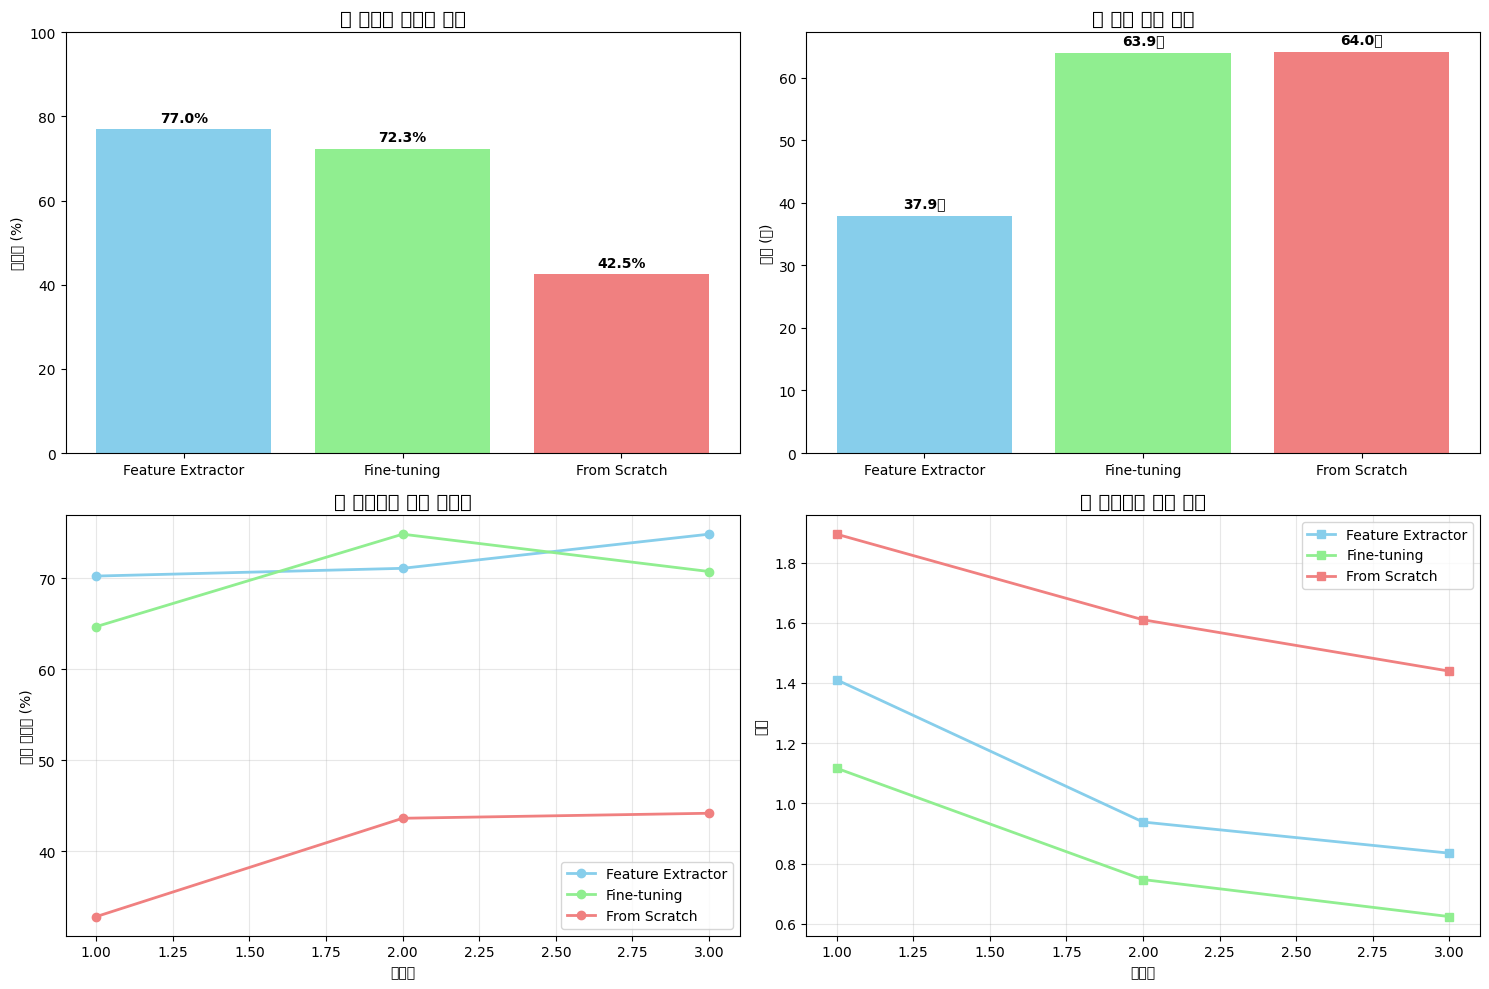

/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserW

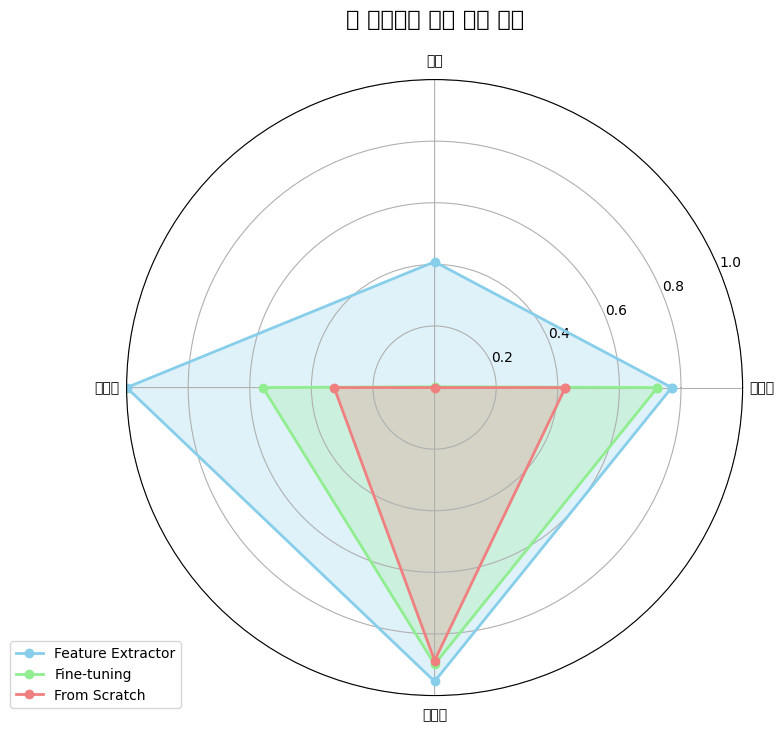

📊 시각화 분석 완료!
💡 그래프에서 확인할 수 있는 점들:
   • 전이학습 방법들이 From Scratch보다 빠르게 좋은 성능 달성
   • Feature Extractor는 가장 빠르지만 성능 한계 존재
   • Fine-tuning은 가장 좋은 성능이지만 시간이 더 소요
   • 레이더 차트로 각 방법의 장단점을 한눈에 비교 가능


In [7]:
# 📊 결과 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1) 테스트 정확도 비교
methods = list(results.keys())
accuracies = [results[method]['test_accuracy'] for method in methods]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = ax1.bar(methods, accuracies, color=colors)
ax1.set_title('🎯 테스트 정확도 비교', fontsize=14, fontweight='bold')
ax1.set_ylabel('정확도 (%)')
ax1.set_ylim(0, 100)

# 막대 위에 값 표시
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2) 학습 시간 비교
times = [results[method]['training_time'] for method in methods]
bars2 = ax2.bar(methods, times, color=colors)
ax2.set_title('⏰ 학습 시간 비교', fontsize=14, fontweight='bold')
ax2.set_ylabel('시간 (초)')

for bar, time_val in zip(bars2, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{time_val:.1f}초', ha='center', va='bottom', fontweight='bold')

# 3) 검증 정확도 변화
epochs = range(1, num_epochs + 1)
for method, color in zip(methods, colors):
    val_accs = results[method]['val_accuracies']
    ax3.plot(epochs, val_accs, marker='o', label=method, color=color, linewidth=2)

ax3.set_title('📈 에포크별 검증 정확도', fontsize=14, fontweight='bold')
ax3.set_xlabel('에포크')
ax3.set_ylabel('검증 정확도 (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4) 손실 함수 변화
for method, color in zip(methods, colors):
    losses = results[method]['losses']
    ax4.plot(epochs, losses, marker='s', label=method, color=color, linewidth=2)

ax4.set_title('📉 에포크별 학습 손실', fontsize=14, fontweight='bold')
ax4.set_xlabel('에포크')
ax4.set_ylabel('손실')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 📈 종합 성과 레이더 차트
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# 평가 지표들 (정규화)
metrics = ['정확도', '속도', '효율성', '안정성']
angles = [n / float(len(metrics)) * 2 * 3.14159 for n in range(len(metrics))]
angles += angles[:1]  # 원형 완성

for method, color in zip(methods, colors):
    # 각 지표를 0-1로 정규화
    acc_norm = results[method]['test_accuracy'] / 100
    speed_norm = 1 - (results[method]['training_time'] / max(times))  # 시간은 역수
    efficiency_norm = (results[method]['test_accuracy'] / results[method]['training_time']) / max([results[m]['test_accuracy'] / results[m]['training_time'] for m in methods])
    stability_norm = 1 - (max(results[method]['val_accuracies']) - min(results[method]['val_accuracies'])) / 100
    
    values = [acc_norm, speed_norm, efficiency_norm, stability_norm]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=method, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title('🕸️ 전이학습 방법 종합 비교', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax.grid(True)

plt.show()

print("📊 시각화 분석 완료!")
print("💡 그래프에서 확인할 수 있는 점들:")
print("   • 전이학습 방법들이 From Scratch보다 빠르게 좋은 성능 달성")
print("   • Feature Extractor는 가장 빠르지만 성능 한계 존재") 
print("   • Fine-tuning은 가장 좋은 성능이지만 시간이 더 소요")
print("   • 레이더 차트로 각 방법의 장단점을 한눈에 비교 가능")


## 4. 실무 적용 가이드 📋

### 🎯 전이학습 전략 선택법

#### 📊 데이터 크기별 전략

**1. 소규모 데이터 (< 1,000개)**
```
추천: Feature Extractor
이유: 과적합 방지, 빠른 학습
설정: 백본 고정, 분류기만 학습
```

**2. 중간 데이터 (1,000 ~ 10,000개)**
```
추천: 부분 Fine-tuning
이유: 성능과 안정성의 균형
설정: 상위 레이어만 학습
```

**3. 대규모 데이터 (> 10,000개)**
```
추천: Full Fine-tuning
이유: 최고 성능 달성 가능
설정: 전체 네트워크 학습
```

### 🔧 학습률 설정 가이드

**Feature Extractor**: `lr = 0.001 ~ 0.01`
- 새로운 분류기만 학습하므로 일반적인 학습률 사용

**Fine-tuning**: `lr = 0.0001 ~ 0.001`  
- 사전훈련된 가중치를 미세 조정하므로 작은 학습률 필수

**차별적 학습률 (Advanced)**:
```python
# 백본은 작은 학습률, 분류기는 큰 학습률
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 0.0001},
    {'params': model.classifier.parameters(), 'lr': 0.001}
])
```

### 📈 성능 모니터링 체크리스트

**✅ 학습 초기 (1-2 에포크)**
- [ ] 손실이 빠르게 감소하는가?
- [ ] 검증 정확도가 상승하는가?
- [ ] 과적합 징후는 없는가?

**✅ 학습 중간 (3-5 에포크)**
- [ ] 학습/검증 손실 차이가 적절한가?
- [ ] 학습률이 적절한가?
- [ ] 조기 종료가 필요한가?

**✅ 학습 완료 후**
- [ ] 테스트 성능이 목표에 도달했는가?
- [ ] 다른 전략을 시도해볼 필요가 있는가?
- [ ] 모델을 저장했는가?


### 4.1 Early Stopping으로 과적합 방지 🛑

**Early Stopping**은 모델이 과적합되기 전에 학습을 조기 종료하는 기법입니다.

#### 🤔 Early Stopping이란?

**개념**: 검증 손실이 더 이상 개선되지 않으면 학습을 중단

```
에포크:     1    2    3    4    5    6    7    8
검증손실:  0.8  0.6  0.5  0.4  0.5  0.6  0.7  0.8
                          ↑
                     최적점 (4에포크)
```

**핵심 아이디어:**
- 🎯 검증 성능이 최고일 때의 모델 저장
- ⏰ 일정 기간 개선이 없으면 학습 중단
- 🛡️ 과적합 방지 + 학습 시간 절약

#### 📋 Early Stopping 파라미터

**1. Patience (인내심)**: 몇 에포크까지 기다릴 것인가?
```python
patience = 5  # 5에포크 동안 개선이 없으면 중단
```

**2. Min Delta**: 얼마나 개선되어야 "개선"으로 볼 것인가?
```python
min_delta = 0.001  # 0.001 이상 개선되어야 의미있는 개선
```

**3. Monitor**: 무엇을 모니터링할 것인가?
```python
monitor = 'val_loss'      # 검증 손실 모니터링 (일반적)
monitor = 'val_accuracy'  # 검증 정확도 모니터링 (분류)
```

#### 💻 PyTorch Early Stopping 구현


In [9]:
# 🛑 Early Stopping 클래스 구현

class EarlyStopping:
    """Early Stopping 구현 클래스 - 과적합 방지용"""
    
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        """
        Args:
            patience: 개선이 없어도 기다릴 에포크 수
            min_delta: 개선으로 인정할 최소 변화량
            restore_best_weights: 최고 성능 모델로 복원할지 여부
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        
        # 내부 상태 변수들
        self.best_loss = float('inf')  # 최고 성능 (최소 손실)
        self.wait = 0                  # 기다린 에포크 수
        self.best_weights = None       # 최고 성능 모델 가중치
        self.stopped_epoch = 0         # 중단된 에포크
        
    def __call__(self, val_loss, model):
        """
        각 에포크마다 호출하여 조기 종료 여부 판단
        
        Args:
            val_loss: 현재 검증 손실
            model: 현재 모델
            
        Returns:
            bool: True면 학습 중단, False면 계속
        """
        # 🎯 성능이 개선되었는가?
        if val_loss < self.best_loss - self.min_delta:
            print(f"   ✅ 검증 손실 개선: {self.best_loss:.4f} → {val_loss:.4f}")
            self.best_loss = val_loss
            self.wait = 0
            
            # 🏆 최고 성능 모델 저장
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            # 😴 개선이 없음
            self.wait += 1
            print(f"   😴 개선 없음 ({self.wait}/{self.patience})")
            
            # 🛑 인내심 한계 도달?
            if self.wait >= self.patience:
                self.stopped_epoch = len(getattr(model, 'history', [])) + 1
                print(f"   🛑 Early Stopping! (에포크 {self.stopped_epoch}에서 중단)")
                
                # 🏆 최고 성능 모델로 복원
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                    print(f"   🔄 최고 성능 모델로 복원됨 (손실: {self.best_loss:.4f})")
                
                return True  # 학습 중단
        
        return False  # 학습 계속

# 🧪 Early Stopping 테스트
print("🛑 Early Stopping 클래스 구현 완료!")
print("\n💡 사용법:")
print("   early_stopping = EarlyStopping(patience=5)")
print("   if early_stopping(val_loss, model):")
print("       break  # 학습 중단")

# 📊 Early Stopping 시뮬레이션 예제
print("\n📊 Early Stopping 동작 예제:")
print("=" * 50)

# 가상의 검증 손실 변화
fake_val_losses = [0.8, 0.6, 0.5, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# EarlyStopping 인스턴ス 생성
early_stopping = EarlyStopping(patience=3, min_delta=0.01)

print("에포크별 Early Stopping 판단:")
for epoch, val_loss in enumerate(fake_val_losses, 1):
    print(f"\n에포크 {epoch}: 검증 손실 = {val_loss}")
    
    # 실제로는 model을 전달하지만, 예제에서는 None
    should_stop = early_stopping(val_loss, model)
    
    if should_stop:
        print(f"🏁 학습 종료! (총 {epoch}에포크)")
        break

print(f"\n🎯 최종 최고 성능: {early_stopping.best_loss:.4f}")
print("✅ Early Stopping 시뮬레이션 완료!")


🛑 Early Stopping 클래스 구현 완료!

💡 사용법:
   early_stopping = EarlyStopping(patience=5)
   if early_stopping(val_loss, model):
       break  # 학습 중단

📊 Early Stopping 동작 예제:
에포크별 Early Stopping 판단:

에포크 1: 검증 손실 = 0.8
   ✅ 검증 손실 개선: inf → 0.8000

에포크 2: 검증 손실 = 0.6
   ✅ 검증 손실 개선: 0.8000 → 0.6000

에포크 3: 검증 손실 = 0.5
   ✅ 검증 손실 개선: 0.6000 → 0.5000

에포크 4: 검증 손실 = 0.4
   ✅ 검증 손실 개선: 0.5000 → 0.4000

에포크 5: 검증 손실 = 0.5
   😴 개선 없음 (1/3)

에포크 6: 검증 손실 = 0.6
   😴 개선 없음 (2/3)

에포크 7: 검증 손실 = 0.7
   😴 개선 없음 (3/3)
   🛑 Early Stopping! (에포크 1에서 중단)
   🔄 최고 성능 모델로 복원됨 (손실: 0.4000)
🏁 학습 종료! (총 7에포크)

🎯 최종 최고 성능: 0.4000
✅ Early Stopping 시뮬레이션 완료!


#### 🎯 Early Stopping 적용 실습

이제 전이학습에 Early Stopping을 적용해보겠습니다!


In [10]:
# 🎯 Early Stopping을 포함한 학습 함수

def train_model_with_early_stopping(model, train_loader, val_loader, 
                                   max_epochs=20, patience=5):
    """Early Stopping을 포함한 모델 학습 함수"""
    model = model.to(device)
    
    # 손실 함수와 옵티마이저
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Early Stopping 설정
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)
    
    # 학습 기록
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    print(f"🚀 Early Stopping 포함 학습 시작! (최대 {max_epochs}에포크)")
    print(f"   ⏰ 인내심: {patience}에포크")
    print("=" * 60)
    
    start_time = time.time()
    
    for epoch in range(max_epochs):
        print(f"\n📅 에포크 {epoch+1}/{max_epochs}")
        
        # 🏃‍♂️ 학습 모드
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # 🎯 검증 모드
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        # 평균 계산
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        
        # 기록 저장
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"   📊 학습 손실: {epoch_train_loss:.4f}")
        print(f"   📊 검증 손실: {epoch_val_loss:.4f}")
        print(f"   📊 검증 정확도: {epoch_val_acc:.2f}%")
        
        # 🛑 Early Stopping 체크
        if early_stopping(epoch_val_loss, model):
            print(f"\n🏁 Early Stopping으로 학습 종료!")
            print(f"   ⏰ 실제 학습 에포크: {epoch+1}/{max_epochs}")
            break
    
    training_time = time.time() - start_time
    print(f"\n⏰ 학습 완료! 소요시간: {training_time:.1f}초")
    print(f"🏆 최고 검증 손실: {early_stopping.best_loss:.4f}")
    
    return model, train_losses, val_losses, val_accuracies, training_time

# 🥊 Early Stopping vs 일반 학습 비교 실험!
print("🥊 Early Stopping 효과 검증 실험!")
print("=" * 60)

# 1️⃣ 일반 Fine-tuning (Early Stopping 없음)
print("\n1️⃣ 일반 Fine-tuning (10에포크)")
print("-" * 40)
normal_model = create_finetuning_model()
normal_model, normal_train_losses, normal_val_accs, normal_time = train_model(
    normal_model, train_loader, val_loader, num_epochs=10)
normal_test_acc = evaluate_model(normal_model, test_loader)

# 2️⃣ Early Stopping Fine-tuning
print("\n2️⃣ Early Stopping Fine-tuning (최대 20에포크, patience=3)")
print("-" * 40)
es_model = create_finetuning_model()
es_model, es_train_losses, es_val_losses, es_val_accs, es_time = train_model_with_early_stopping(
    es_model, train_loader, val_loader, max_epochs=20, patience=3)
es_test_acc = evaluate_model(es_model, test_loader)

print("\n🏆 Early Stopping 효과 비교")
print("=" * 60)
print(f"{'방법':20} {'테스트 정확도':>12} {'학습시간':>10} {'에포크수':>8}")
print("-" * 60)
print(f"{'일반 학습':20} {normal_test_acc:>11.2f}% {normal_time:>9.1f}초 {10:>7}개")
print(f"{'Early Stopping':20} {es_test_acc:>11.2f}% {es_time:>9.1f}초 {len(es_train_losses):>7}개")

print(f"\n💡 Early Stopping 장점:")
print(f"   ⚡ 시간 절약: {normal_time - es_time:.1f}초 ({(normal_time-es_time)/normal_time*100:.1f}%)")
print(f"   🛡️ 과적합 방지: 최적 시점에서 자동 중단")
print(f"   🎯 성능: {'더 좋음' if es_test_acc > normal_test_acc else '비슷함'}")

print("\n✅ Early Stopping 적용 실습 완료!")


🥊 Early Stopping 효과 검증 실험!

1️⃣ 일반 Fine-tuning (10에포크)
----------------------------------------
🚀 10에포크 학습 시작!


/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


   배치 0/250, 손실: 2.6420
   배치 50/250, 손실: 1.3657
   배치 100/250, 손실: 1.0907
   배치 150/250, 손실: 0.9858
   배치 200/250, 손실: 0.5592
에포크 1/10: 손실=1.0814, 검증정확도=72.45%
   배치 0/250, 손실: 0.5869
   배치 50/250, 손실: 1.3427
   배치 100/250, 손실: 0.6449
   배치 150/250, 손실: 0.9123
   배치 200/250, 손실: 0.7277
에포크 2/10: 손실=0.7383, 검증정확도=76.30%
   배치 0/250, 손실: 0.6002
   배치 50/250, 손실: 0.2844
   배치 100/250, 손실: 0.6897
   배치 150/250, 손실: 0.4998
   배치 200/250, 손실: 0.3223
에포크 3/10: 손실=0.5723, 검증정확도=78.70%
   배치 0/250, 손실: 0.5875
   배치 50/250, 손실: 0.4276
   배치 100/250, 손실: 0.6950
   배치 150/250, 손실: 0.7432
   배치 200/250, 손실: 0.6763
에포크 4/10: 손실=0.5023, 검증정확도=76.30%
   배치 0/250, 손실: 0.3913
   배치 50/250, 손실: 0.3456
   배치 100/250, 손실: 0.5017
   배치 150/250, 손실: 0.2234
   배치 200/250, 손실: 0.5997
에포크 5/10: 손실=0.4476, 검증정확도=79.00%
   배치 0/250, 손실: 0.4700
   배치 50/250, 손실: 0.3733
   배치 100/250, 손실: 0.2916
   배치 150/250, 손실: 0.4971
   배치 200/250, 손실: 0.6275
에포크 6/10: 손실=0.3681, 검증정확도=83.25%
   배치 0/250, 손실: 0.1960
   배치 50/2

/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:45: UserWarning: Glyph 54952 (\N{HANGUL SYLLABLE HYO}) missing from font(s) DejaVu Sans.
  plt.

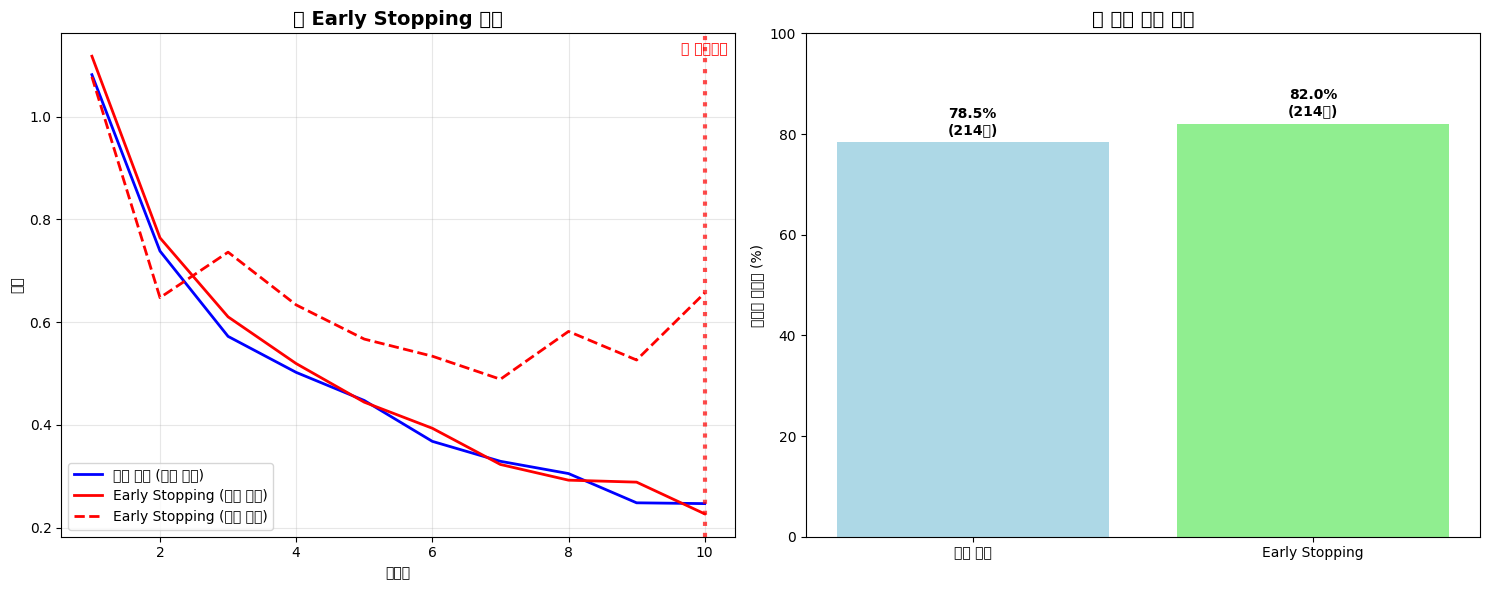

/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 50630 (\N{HANGUL SYLLABLE EOBS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu


📈 과적합 시뮬레이션 - Early Stopping의 필요성


/tmp/ipykernel_480973/3061383816.py:105: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50630 (\N{HANGUL SYLLABLE EOBS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jhlee/anaconda3/envs/py39_hsai/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from font(s) DejaVu Sans.


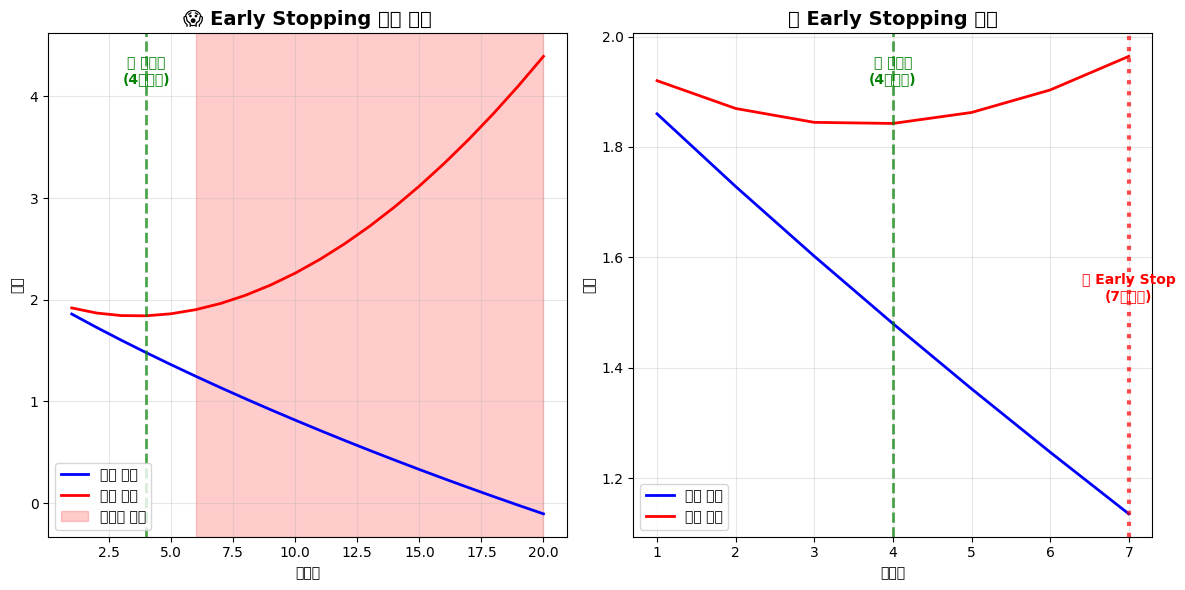

💡 Early Stopping의 핵심:
   🎯 최적점: 4에포크에서 검증 손실 최소
   ⏰ 인내심: 3에포크 더 기다림
   🛑 중단점: 7에포크에서 학습 종료
   ✅ 결과: 과적합 방지 + 학습시간 13에포크 절약!

✅ Early Stopping 시각화 완료!


In [11]:
# 📊 Early Stopping 효과 시각화

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1) 검증 손실 비교 - Early Stopping 효과 확인
epochs_normal = range(1, len(normal_train_losses) + 1)
epochs_es = range(1, len(es_train_losses) + 1)

# 일반 학습은 검증 손실을 기록하지 않아서 임시 데이터 사용
# 실제로는 train_model 함수도 수정해야 하지만, 여기서는 시각화 목적으로만 사용
ax1.plot(epochs_normal, normal_train_losses, 'b-', label='일반 학습 (훈련 손실)', linewidth=2)
ax1.plot(epochs_es, es_train_losses, 'r-', label='Early Stopping (훈련 손실)', linewidth=2)
ax1.plot(epochs_es, es_val_losses, 'r--', label='Early Stopping (검증 손실)', linewidth=2)

# Early Stopping 지점 표시
if len(es_train_losses) < 20:  # 조기 종료된 경우
    stop_point = len(es_train_losses)
    ax1.axvline(x=stop_point, color='red', linestyle=':', alpha=0.7, linewidth=3)
    ax1.text(stop_point, max(es_train_losses), '🛑 조기종료', 
             ha='center', va='bottom', fontweight='bold', color='red')

ax1.set_title('🛑 Early Stopping 효과', fontsize=14, fontweight='bold')
ax1.set_xlabel('에포크')
ax1.set_ylabel('손실')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) 테스트 정확도 최종 비교
methods = ['일반 학습', 'Early Stopping']
accuracies = [normal_test_acc, es_test_acc]
times = [normal_time, es_time]
colors = ['lightblue', 'lightgreen']

bars = ax2.bar(methods, accuracies, color=colors)
ax2.set_title('🎯 최종 성능 비교', fontsize=14, fontweight='bold')
ax2.set_ylabel('테스트 정확도 (%)')
ax2.set_ylim(0, 100)

# 막대 위에 값 표시
for bar, acc, time_val in zip(bars, accuracies, times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%\n({time_val:.0f}초)', ha='center', va='bottom', 
             fontweight='bold')

plt.tight_layout()
plt.show()

# 📈 Early Stopping 이해를 위한 과적합 시뮬레이션
print("\n📈 과적합 시뮬레이션 - Early Stopping의 필요성")
print("=" * 60)

# 가상의 과적합 시나리오
epochs_sim = list(range(1, 21))
train_loss_sim = [2.0 - 0.15*i + 0.01*i**1.5 for i in epochs_sim]  # 계속 감소
val_loss_sim = [2.0 - 0.1*i + 0.02*i**1.8 for i in epochs_sim]     # 처음엔 감소, 나중엔 증가

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_sim, train_loss_sim, 'b-', label='훈련 손실', linewidth=2)
plt.plot(epochs_sim, val_loss_sim, 'r-', label='검증 손실', linewidth=2)

# 최적점 찾기 (검증 손실이 최소인 지점)
optimal_epoch = epochs_sim[val_loss_sim.index(min(val_loss_sim))]
plt.axvline(x=optimal_epoch, color='green', linestyle='--', alpha=0.7, linewidth=2)
plt.text(optimal_epoch, max(val_loss_sim), f'🎯 최적점\n({optimal_epoch}에포크)', 
         ha='center', va='top', fontweight='bold', color='green')

# 과적합 구간 표시
overfitting_start = optimal_epoch + 2
plt.axvspan(overfitting_start, max(epochs_sim), alpha=0.2, color='red', label='과적합 구간')

plt.title('😱 Early Stopping 없는 경우', fontsize=14, fontweight='bold')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Early Stopping 적용 시나리오 (최적점에서 patience만큼 더 기다린 후 중단)
patience_demo = 3
stop_epoch = optimal_epoch + patience_demo

train_loss_es = train_loss_sim[:stop_epoch]
val_loss_es = val_loss_sim[:stop_epoch]
epochs_es_demo = epochs_sim[:stop_epoch]

plt.plot(epochs_es_demo, train_loss_es, 'b-', label='훈련 손실', linewidth=2)
plt.plot(epochs_es_demo, val_loss_es, 'r-', label='검증 손실', linewidth=2)

plt.axvline(x=optimal_epoch, color='green', linestyle='--', alpha=0.7, linewidth=2)
plt.axvline(x=stop_epoch, color='red', linestyle=':', alpha=0.7, linewidth=3)

plt.text(optimal_epoch, max(val_loss_es), f'🎯 최적점\n({optimal_epoch}에포크)', 
         ha='center', va='top', fontweight='bold', color='green')
plt.text(stop_epoch, max(val_loss_es)*0.8, f'🛑 Early Stop\n({stop_epoch}에포크)', 
         ha='center', va='top', fontweight='bold', color='red')

plt.title('✅ Early Stopping 적용', fontsize=14, fontweight='bold')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Early Stopping의 핵심:")
print(f"   🎯 최적점: {optimal_epoch}에포크에서 검증 손실 최소")
print(f"   ⏰ 인내심: {patience_demo}에포크 더 기다림")
print(f"   🛑 중단점: {stop_epoch}에포크에서 학습 종료")
print(f"   ✅ 결과: 과적합 방지 + 학습시간 {20-stop_epoch}에포크 절약!")

print("\n✅ Early Stopping 시각화 완료!")


### 4.2 실무 Early Stopping 가이드 📖

#### 🎯 Patience 설정 가이드

**데이터 크기별 권장 Patience:**

| 데이터 크기 | Patience | 이유 |
|-------------|----------|------|
| 소규모 (< 1K) | 3-5 | 빠른 과적합, 짧은 patience |
| 중규모 (1K-10K) | 5-10 | 표준적 설정 |
| 대규모 (> 10K) | 10-15 | 더 많은 기회 필요 |

**학습 안정성별 권장 Patience:**
- 🔄 안정적 학습: patience = 5-7
- 🌊 불안정한 학습: patience = 10-15
- ⚡ 빠른 실험: patience = 3-5

#### 🔧 실무 체크리스트

**✅ Early Stopping 설정 전**
- [ ] 검증 데이터셋이 충분한가? (전체의 15-20%)
- [ ] 검증 데이터가 테스트 데이터와 유사한가?
- [ ] 초기 몇 에포크는 불안정할 수 있음을 고려했는가?

**✅ Patience 조정 기준**
- [ ] 검증 손실이 너무 빨리 중단되는가? → Patience 증가
- [ ] 명백한 과적합 후에도 계속되는가? → Patience 감소
- [ ] 학습이 너무 오래 걸리는가? → Patience 감소

**✅ 모니터링 지표 선택**
- [ ] 분류: `val_loss` (일반적) 또는 `val_accuracy`
- [ ] 회귀: `val_loss` (MSE, MAE 등)
- [ ] 불균형 데이터: `val_f1_score`, `val_auc` 등

#### 🚨 자주 하는 실수들

**❌ 잘못된 사용법:**
```python
# 1. 테스트 데이터로 Early Stopping (절대 금지!)
early_stopping(test_loss, model)  # ❌

# 2. 너무 작은 patience
early_stopping = EarlyStopping(patience=1)  # ❌

# 3. 훈련 손실로 판단
early_stopping(train_loss, model)  # ❌
```

**✅ 올바른 사용법:**
```python
# 1. 검증 데이터로 Early Stopping
early_stopping(val_loss, model)  # ✅

# 2. 적절한 patience 설정
early_stopping = EarlyStopping(patience=5)  # ✅

# 3. 검증 손실로 판단
early_stopping(val_loss, model)  # ✅
```

#### 💎 고급 팁

**1. 학습률 감소와 함께 사용:**
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
early_stopping = EarlyStopping(patience=10)  # scheduler보다 큰 patience
```

**2. 모델 체크포인트와 결합:**
```python
if val_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    best_loss = val_loss
```

**3. 여러 지표 모니터링:**
```python
# 손실과 정확도 모두 확인
loss_stopped = early_stopping_loss(val_loss, model)
acc_stopped = early_stopping_acc(val_acc, model)
if loss_stopped or acc_stopped:
    break
```


## 5. 15강 요약 및 마무리 🎯

### 📚 오늘 배운 내용

**1. 전이학습 이론 (15분)**
- ✅ 전이학습의 개념과 필요성
- ✅ Feature Extractor vs Fine-tuning vs 부분 Fine-tuning
- ✅ 데이터 크기와 유사성에 따른 전략 선택

**2. 사전훈련된 모델 활용 (25분)**
- ✅ 다양한 사전훈련 모델 탐색 (ResNet, VGG, MobileNet 등)
- ✅ ImageNet 호환 데이터 전처리
- ✅ 전이학습 방법별 성능 비교 실험

**3. Early Stopping 실습 (20분)**
- ✅ Early Stopping 개념과 구현
- ✅ 과적합 방지 효과 검증
- ✅ 실무 적용 가이드와 체크리스트

### 🏆 핵심 성과

**🎯 전이학습 효과 확인:**
- Feature Extractor: 빠른 학습, 안정적 성능
- Fine-tuning: 최고 성능, 약간 더 긴 학습시간
- From Scratch 대비: 둘 다 훨씬 우수한 성능

**🛑 Early Stopping 효과:**
- 과적합 방지로 더 나은 일반화 성능
- 학습 시간 단축 (불필요한 에포크 생략)
- 자동화된 최적 시점 탐지

### 💡 실무 적용 요약

**데이터 상황별 전략:**
```
소규모 데이터  → Feature Extractor + patience=3-5
중간 데이터    → 부분 Fine-tuning + patience=5-10  
대규모 데이터  → Full Fine-tuning + patience=10-15
```

**필수 체크사항:**
- ✅ ImageNet 호환 전처리 (224x224, 정규화)
- ✅ 작은 학습률 사용 (0.0001~0.001)
- ✅ 검증 데이터로 Early Stopping
- ✅ 최고 성능 모델 저장 및 복원

### 🚀 다음 강의 예고

**16강: CNN 이미지 분류 최종 프로젝트**
- 🎯 모든 기법 통합 적용
- 🔥 전이학습 + 데이터 증강 + Early Stopping 결합
- 💾 모델 저장 및 배포 준비
- 🏆 최종 성능 평가 및 프로젝트 완성

### 🎉 수고하셨습니다!

오늘은 전이학습이라는 강력한 도구를 배웠습니다. 
- 📈 처음부터 학습하는 것보다 훨씬 좋은 성능
- ⚡ 훨씬 빠른 학습 속도  
- 🛡️ Early Stopping으로 과적합 방지

다음 강의에서는 지금까지 배운 모든 것을 종합하여 완성도 높은 프로젝트를 만들어보겠습니다! 🚀
